In [57]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import time
from drone_vrp import*

In [58]:
import multiprocessing

#### Replace the Fitness(population[i]).routeDistance() to our own objective function. ####
#### Replace  otherParamters to our own parameters which needed to initial and caculate the objective function

#### Population will be the list of customer service station route ####

#### Fitness(population[i]).routeDistance() will be the service time from route ####

#### So that  fitnessResults will be list the 1/serviceTime from the list of route ####

In [59]:
def multiprocessing_getServiceTime(population,dvrp,i, fitnessResults):
    print('start to run:', i)
    dvrp1 = copy.deepcopy(dvrp)
    dvrp1.customers = population[i]
    dvrp1.split_route();
    fitnessResults[i] = 1/dvrp1.objective()
    
    

In [70]:
def rankRoutes(population, dvrp):
    fitnessResults = {}
    for i in range(0,len(population)):
        #print('check population',i)
        #print('population id:')
        #for custom in population[i]:
         #   print(custom.id)
        #print('Customers',i,)
        dvrp1 = copy.deepcopy(dvrp)
        dvrp1.customers = population[i]
        dvrp1.split_route();
        fitnessResults[i] = 1/dvrp1.objective()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [82]:
def PrintCustomers(customers):
    s = "("
    for custom in customers:
        s+=str(custom.id) + ', '
    s= s[0:-2]+")"
    return s;

#### Main method of GA, please replace the otherParamters with our own Parameters need####

next gen 100 parent -> spiltroute for each parent -> 100 results -> rankResult -> 20 best parent +80 child -> 100 child ->1% mutate -> next gen 100 parent -> loop

Mutate 1% (city1, city2 ..... cityn) -> mutate (city1, cityn ..... city2)

loop next gen 500 -> 100 gens ->best 1 output

In [89]:
'''
Description: Main method of GA
Reference: 
https://levelup.gitconnected.com/how-to-implement-a-traveling-salesman-problem-genetic-algorithm-in-python-ea32c7bef20f
https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
https://github.com/rocreguant/personal_blog/blob/main/Genetic_Algorithm_Python_Example/Traveling_Salesman_Problem.ipynb
https://github.com/ezstoltz/genetic-algorithm/blob/master/genetic_algorithm_TSP.ipynb

'''

## Create our initial population
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    
    return route

#Create first "population" (list of routes)
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

#Create mating pool
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
        #print('len of selectionResults', len(selectionResults))
    return selectionResults

#Create a crossover function for two parents to create one child
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

#Create a crossover function for two parents to create one child
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

#Create function to run crossover over full mating pool
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    for i in range(0,len(children)):
        print("child",i,PrintCustomers(children[i]))
    return children

#Create function to mutate a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

#Create function to run mutation over entire population
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    for i in range(0,len(mutatedPop)):
        print("mutate child",i,PrintCustomers(mutatedPop[i]))
    return mutatedPop

#Put all steps together to create the next generation
def nextGeneration(currentGen, eliteSize, mutationRate, otherParamters):
    popRanked = rankRoutes(currentGen, otherParamters)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration,popRanked

#Final step: create the genetic algorithm
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations, dvrp):
    print(population)
    pop = initialPopulation(popSize, population)
    for i in range(0,len(pop)):
        print("Initial pop",i,PrintCustomers(pop[i]))
    popRanked = rankRoutes(pop, dvrp);
    print("Initial Service Time: " + str(1 / popRanked[0][1]))
    progress = []
    progress.append(1 / popRanked[0][1])
    for i in range(0, generations):
        print('start generations:', i+1)
        pop,popRanked = nextGeneration(pop, eliteSize, mutationRate, dvrp)
        
        progress.append(1 / popRanked[0][1])
    
    print("Final Service Time: " + str(1 / popRanked[0][1]))
    plt.plot(progress)
    plt.ylabel('Service Time')
    plt.xlabel('Generation')
    plt.show()
    bestRouteIndex = popRanked[0][0]
    bestRoute = pop[bestRouteIndex]
    dvrp1 = copy.deepcopy(dvrp)
    dvrp1.customers = bestRoute
    dvrp1.split_route();
    
    return dvrp1


## Running the genetic algorithm

### Please replace the cityList with our own Customers Service Satation from either hardcode or data import,
### Please replace the otherParamters with our own Parameters needed for mode from either hardcode or data import

[<drone_vrp.Customer object at 0x000002897F9BCA90>, <drone_vrp.Customer object at 0x000002897FC0DEB0>, <drone_vrp.Customer object at 0x000002897FC0DD00>, <drone_vrp.Customer object at 0x000002897FC0DE80>, <drone_vrp.Customer object at 0x000002897FC0DC70>, <drone_vrp.Customer object at 0x000002897FC0DCD0>, <drone_vrp.Customer object at 0x000002897FC0DC10>, <drone_vrp.Customer object at 0x000002897FC2A7C0>, <drone_vrp.Customer object at 0x000002897FC2A9A0>, <drone_vrp.Customer object at 0x000002897FC2A5B0>, <drone_vrp.Customer object at 0x000002897FAA2940>, <drone_vrp.Customer object at 0x000002897FAA2040>, <drone_vrp.Customer object at 0x000002897FAA20D0>, <drone_vrp.Customer object at 0x000002897FAA2A00>, <drone_vrp.Customer object at 0x000002897FD38B20>]
Initial pop 0 (14, 12, 19, 18, 8, 9, 15, 17, 16, 7, 13, 6, 20, 10, 11)
Initial pop 1 (12, 7, 9, 11, 16, 20, 8, 10, 15, 19, 14, 13, 6, 17, 18)
Initial pop 2 (19, 10, 8, 17, 6, 20, 9, 11, 12, 18, 7, 16, 13, 15, 14)
Initial pop 3 (6, 7, 

child 0 (12, 18, 20, 19, 15, 9, 10, 16, 11, 6, 7, 8, 13, 17, 14)
child 1 (12, 18, 20, 19, 15, 9, 10, 16, 11, 6, 7, 8, 13, 17, 14)
child 2 (20, 19, 15, 9, 10, 16, 11, 6, 17, 7, 13, 12, 8, 14, 18)
child 3 (17, 12, 18, 14, 16, 11, 10, 6, 15, 9, 7, 19, 8, 13, 20)
child 4 (7, 11, 6, 15, 8, 19, 18, 20, 13, 17, 12, 14, 16, 10, 9)
child 5 (6, 15, 7, 9, 19, 12, 18, 20, 10, 16, 11, 8, 13, 17, 14)
child 6 (6, 15, 7, 9, 19, 8, 11, 16, 17, 10, 12, 13, 20, 14, 18)
child 7 (19, 8, 13, 20, 17, 12, 18, 14, 16, 15, 10, 7, 11, 6, 9)
child 8 (6, 7, 17, 12, 13, 8, 18, 11, 9, 19, 15, 16, 20, 14, 10)
child 9 (6, 9, 19, 17, 7, 15, 12, 18, 20, 10, 16, 11, 8, 13, 14)
child 10 (18, 11, 9, 19, 7, 15, 16, 12, 20, 10, 6, 8, 13, 17, 14)
child 11 (17, 6, 15, 9, 12, 7, 16, 14, 19, 18, 20, 11, 8, 10, 13)
child 12 (20, 11, 8, 17, 10, 7, 19, 13, 6, 15, 9, 12, 18, 14, 16)
child 13 (12, 18, 20, 19, 15, 9, 10, 16, 11, 6, 7, 17, 13, 8, 14)
child 14 (12, 18, 20, 19, 11, 6, 9, 17, 7, 15, 13, 16, 8, 14, 10)
child 15 (18, 11, 9,

child 0 (18, 20, 19, 15, 9, 10, 16, 11, 7, 12, 6, 8, 13, 17, 14)
child 1 (18, 20, 19, 15, 9, 10, 16, 11, 7, 12, 6, 8, 13, 17, 14)
child 2 (7, 8, 20, 19, 15, 9, 11, 16, 17, 10, 12, 13, 6, 18, 14)
child 3 (18, 20, 19, 15, 9, 6, 7, 8, 11, 16, 17, 10, 12, 13, 14)
child 4 (20, 19, 15, 9, 10, 16, 11, 6, 7, 8, 18, 12, 13, 17, 14)
child 5 (9, 8, 11, 16, 20, 19, 15, 10, 17, 13, 6, 7, 12, 14, 18)
child 6 (7, 18, 20, 19, 10, 16, 11, 6, 17, 12, 15, 9, 8, 13, 14)
child 7 (20, 19, 15, 9, 10, 17, 13, 6, 7, 16, 11, 8, 12, 18, 14)
child 8 (19, 18, 20, 15, 9, 10, 16, 11, 6, 7, 8, 12, 13, 17, 14)
child 9 (9, 10, 16, 11, 7, 15, 6, 8, 12, 18, 20, 19, 13, 17, 14)
child 10 (19, 15, 9, 10, 7, 13, 11, 12, 18, 20, 16, 6, 17, 8, 14)
child 11 (13, 6, 19, 7, 9, 15, 8, 11, 16, 17, 10, 12, 20, 18, 14)
child 12 (19, 7, 9, 10, 16, 11, 15, 6, 8, 12, 18, 20, 17, 13, 14)
child 13 (17, 18, 20, 19, 15, 9, 10, 16, 11, 7, 12, 6, 8, 13, 14)
child 14 (6, 8, 9, 10, 16, 11, 7, 15, 12, 18, 20, 19, 17, 13, 14)
child 15 (6, 7, 8, 1

child 0 (16, 11, 7, 15, 12, 8, 6, 18, 9, 10, 13, 20, 19, 14, 17)
child 1 (18, 20, 19, 15, 9, 10, 16, 11, 7, 12, 6, 8, 13, 17, 14)
child 2 (14, 18, 20, 19, 15, 9, 10, 16, 11, 7, 12, 6, 8, 13, 17)
child 3 (10, 14, 16, 11, 7, 15, 12, 8, 6, 18, 9, 13, 20, 19, 17)
child 4 (19, 15, 9, 10, 16, 11, 7, 12, 6, 8, 13, 17, 18, 20, 14)
child 5 (18, 13, 6, 19, 7, 9, 15, 8, 10, 16, 11, 12, 20, 17, 14)
child 6 (14, 10, 7, 13, 11, 18, 20, 19, 15, 6, 8, 17, 12, 9, 16)
child 7 (10, 16, 18, 11, 19, 15, 7, 12, 20, 9, 13, 6, 8, 17, 14)
child 8 (12, 6, 8, 13, 17, 15, 9, 10, 16, 11, 7, 18, 20, 19, 14)
child 9 (13, 17, 18, 20, 15, 9, 10, 16, 11, 6, 7, 8, 12, 19, 14)
child 10 (7, 8, 12, 10, 13, 11, 18, 20, 19, 15, 6, 14, 17, 9, 16)
child 11 (17, 18, 20, 19, 15, 9, 10, 16, 11, 7, 12, 6, 8, 13, 14)
child 12 (10, 16, 11, 7, 12, 6, 8, 18, 20, 19, 15, 9, 13, 17, 14)
child 13 (7, 13, 11, 18, 20, 19, 15, 6, 8, 12, 9, 10, 14, 17, 16)
child 14 (13, 17, 15, 9, 10, 19, 16, 11, 7, 12, 6, 8, 18, 20, 14)
child 15 (17, 15, 9,

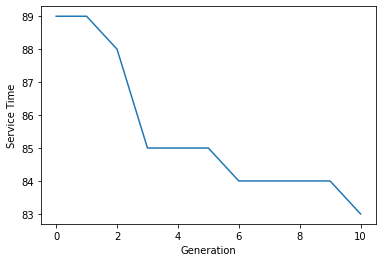

running time:  62.45317363739014


In [91]:
if __name__ == '__main__':
    config_file = "config.ini"
    data_type = "data-medium"
    
    # # load data and random seed
    parsed = Parser(config_file, data_type)
    
    dvrp = DVRP(parsed.warehouses, parsed.customers, parsed.trucks, parsed.drones, parsed.map_size)
    #random_state = rnd.RandomState(seed)

    start = time.time()

    
    bestRoute = geneticAlgorithm(population=dvrp.customers, popSize=20, eliteSize=2, mutationRate=0.01, generations=10,dvrp=dvrp)
    
    end = time.time()
    print('running time: ',end - start)
    

[<drone_vrp.Customer object at 0x000002897FB78280>, <drone_vrp.Customer object at 0x000002897FB780A0>, <drone_vrp.Customer object at 0x000002897FB787F0>, <drone_vrp.Customer object at 0x000002897FB78730>, <drone_vrp.Customer object at 0x000002897FC00910>, <drone_vrp.Customer object at 0x000002897FC00F10>, <drone_vrp.Customer object at 0x000002897FC00D90>, <drone_vrp.Customer object at 0x000002897FC00D30>, <drone_vrp.Customer object at 0x000002897FC00F70>, <drone_vrp.Customer object at 0x000002897FC003D0>, <drone_vrp.Customer object at 0x000002897FC58610>, <drone_vrp.Customer object at 0x000002897FC58940>, <drone_vrp.Customer object at 0x000002897FC58130>, <drone_vrp.Customer object at 0x000002897FC587F0>, <drone_vrp.Customer object at 0x000002897FC58280>]
check population 0
check population 1
check population 2
check population 3
check population 4
check population 5
check population 6
check population 7
check population 8
check population 9
check population 10
check population 11
chec

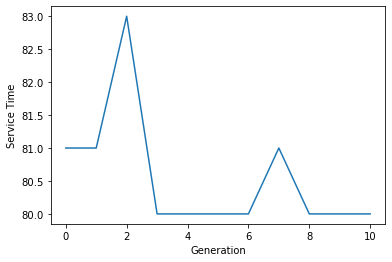

running time:  121.61793041229248


In [31]:
import numpy.random as rnd
if __name__ == '__main__':
    config_file = "config.ini"
    data_type = "data-medium"
    
    # # load data and random seed
    parsed = Parser(config_file, data_type)
    
    dvrp = DVRP(parsed.warehouses, parsed.customers, parsed.trucks, parsed.drones, parsed.map_size)
    random_state = rnd.RandomState(200)


    start = time.time()

    
    bestRoute = geneticAlgorithm(population=dvrp.customers, popSize=20, eliteSize=2, mutationRate=0.01, generations=10,dvrp=dvrp)
    
    end = time.time()
    print('running time: ',end - start)

In [42]:
random_state = rnd.RandomState(200)
random_state.random()

0.9476322568516703

In [55]:
import random as rnd2

In [56]:
rnd2.sample([1,2,3],3)

[1, 3, 2]